# 1. XGBoost(eXtra Gradient Boost)의 개요[](https://injo.tistory.com/44#1.-XGBoost(eXtra-Gradient-Boost)%EC%9D%98-%EA%B0%9C%EC%9A%94)

트리 기반의 알고리즘의 앙상블 학습에서 각광받는 알고리즘 중 하나입니다.  
GBM에 기반하고 있지만, GBM의 단점인 느린 수행시간, 과적합 규제 등을 해결한 알고리즘입니다.

### XGBoost의 주요장점[](https://injo.tistory.com/44#XGBoost%EC%9D%98-%EC%A3%BC%EC%9A%94%EC%9E%A5%EC%A0%90)

(1) 뛰어난 예측 성능  
(2) GBM 대비 빠른 수행 시간  
(3) 과적합 규제(Overfitting Regularization)  
(4) Tree pruning(트리 가지치기) : 긍정 이득이 없는 분할을 가지치기해서 분할 수를 줄임  
(5) 자체 내장된 교차 검증

-   반복 수행시마다 내부적으로 교차검증을 수행해 최적회된 반복 수행횟수를 가질 수 있음
-   지정된 반복횟수가 아니라 교차검증을 통해 평가 데이트세트의 평가 값이 최적화되면 반복을 중간에 멈출 수 있는 기능이 있음  
    

(6) 결손값 자체 처리

XGBoost는 독자적인 XGBoost 모듈과 사이킷런 프레임워크 기반의 모듈이 존재합니다.  
독자적인 모듈은 고유의 API와 하이퍼파라미터를 사용하지만, 사이킷런 기반 모듈에서는 다른 Estimator와 동일한 사용법을 가지고 있습니다.

In [1]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


위의 데이터셋에서 악성종양은 0, 양성은 1 값으로 되어 있음

In [2]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [3]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)



파이썬래퍼 XGBoost와 사이킷런래퍼 XGBoost의 가장 큰 차이는  
파이썬래퍼는 학습용과 테스트 데이터 세트를 위해 별도의 DMatrix를 생성한다는 것입니다.  
**DMatrix**  : 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트

-   주요 입력 파라미터는 data(피처 데이터 세트)와 label  
    (분류: 레이블 데이터 세트/회귀: 숫자형인 종속값 데이터 세트)
-   판다스의 DataFrame으로 데이터 인터페이스를 하기 위해서는 DataFrame.values를 이용해 넘파이로 일차변환 한 뒤에 DMatrix 변환을 적용

In [4]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [5]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 3,
         'eta' : 0.1, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 }

num_rounds = 400


파이썬래퍼 XGBoost에서 하이퍼 파라미터를 xgboost 모듈의  **train( )**  함수에 파라미터로 전달합니다.  
(사이킷런 래퍼는 Estimator 생성자를 하이퍼 파라미터로 전달)

**early_stopping_rounds**  파라미터 : 조기 중단을 위한 라운드를 설정합니다.  
조기 중단 기능 수행을 위해서는 반드시 eval_set과 eval_metric이 함께 설정되어야 합니다.

-   **eval_set**  : 성능평가를 위한 평가용 데이터 세트를 설정  
    
-   **eval_metric**  : 평가 세트에 적용할 성능 평가 방법  
    (반복마다 eval_set으로 지정된 데이터 세트에서 eval_metric의 지정된 평가 지표로 예측 오류를 측정)

train() 함수를 호출하면 xgboost가 반복 시마다 evals에 표시된 데이터 세트에 대해 평가 지표를 출력합니다.  
그 후 학습이 완료된 모델 객체를 반환합니다.

In [6]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[15:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-loglo


train( ) 을 통해 학습을 수행하면 반복시 train-logloss와 eval-logloss가 지속적으로 감소합니다.  
xgboost를 이용해 학습이 완료됐으면 predict() 메서드를 이용해 예측을 수행합니다.  
여기서 파이썬 래퍼는 예측 결과를 추정할 수 있는 호가률 값을 반환합니다.(반면 사이킷런 래퍼는 클래스 값을 반환)

In [7]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [8]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [9]:
get_clf_eval(y_test, preds)

오차행렬:
 [[35  2]
 [ 1 76]]

정확도: 0.9737
정밀도: 0.9744
재현율: 0.9870
F1: 0.9806
AUC: 0.9665


Feature importance를 시각화할 때,  
→ 기본 평가 지료로 f1스코어를 기반으로 각 feature의 중요도를 나타냅니다.  
→ 사이킷런 래퍼는 estimator 객체의 feature_importances_  속성을 이용해 시각화 코드를 직접 작성해야 합니다.  
→ 반면, 파이썬 래퍼는 plot_importance()를 이용해 바로 피처 중요 코드를 시각화 할 수 있습니다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

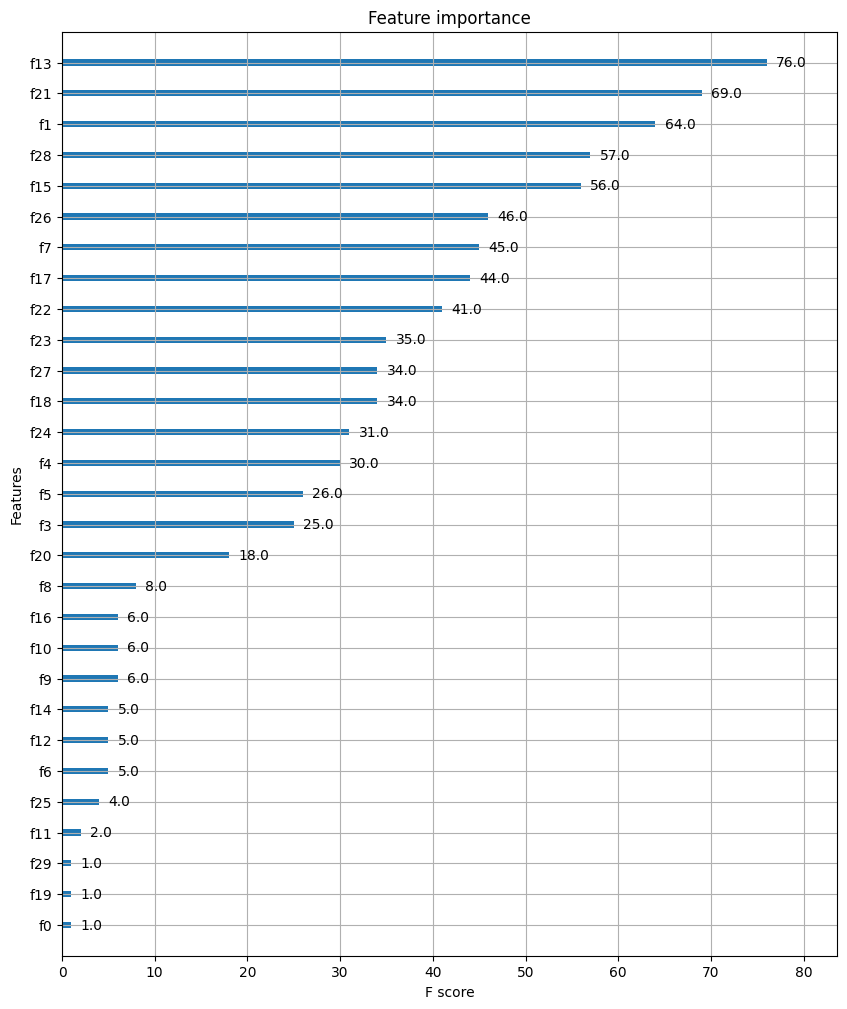

In [12]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

다만, xgboost 넘파이 기반의 피처 데이터로 학습 시에 피처명을 제대로 알 수 없으므로
피처별로 f자 뒤에 순서를 붙여 X축에 피처들로 나열합니다.(f0는 첫번째 피처, f1는 두번째 피처를 의미)


### 파이썬 래퍼의 교차 검증 수행 및 최적 파라미터 구하기[¶](https://injo.tistory.com/44#%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%9E%98%ED%8D%BC%EC%9D%98-%EA%B5%90%EC%B0%A8-%EA%B2%80%EC%A6%9D-%EC%88%98%ED%96%89-%EB%B0%8F-%EC%B5%9C%EC%A0%81-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%EA%B5%AC%ED%95%98%EA%B8%B0)

: xgboost는 사이킷런의 GridSearchCV와 유사하게  **cv( )**를 API로 제공합니다.

**xgb.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False,  
folds=None, metrics=(),obj=None, feval=None, maximize=False,  
early_stopping_rounds=None, fpreproc=None, as_pandas=True,  
verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)**

-   **params(dict)**: 부스터 파라미터
-   **dtrain(DMatrix)**  : 학습 데이터
-   **num_boost_round(int)**  : 부스팅 반복횟수
-   **nfold(int)**  : CV폴드 개수
-   **stratified(bool)**  : CV수행시 샘플을 균등하게 추출할지 여부
-   **metrics(string or list of strings)**  : CV 수행시 모니터링할 성능 평가 지표
-   **early_stopping_rounds(int)**  : 조기중단을 활성화시킴. 반복횟수 지정

xgv.cv의 반환 값은 데이터프레임 형태입니다.


### 특징[](https://injo.tistory.com/44#%ED%8A%B9%EC%A7%95)

-   사이킷런의 기본 Estimator를 이용해 만들어 fit()과 predict()만으로 학습과 예측이 가능
-   GridSearchCV,Pipeline 등 사이킷런의 유틸리티를 그대로 사용 가능
-   분류 : XGBClassifier / 회귀 : XGBRegressor

### 파이썬 래퍼와 비교시 달라진 파라미터[](https://injo.tistory.com/44#%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%9E%98%ED%8D%BC%EC%99%80-%EB%B9%84%EA%B5%90%EC%8B%9C-%EB%8B%AC%EB%9D%BC%EC%A7%84-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0)

-   eta → learning_rate
-   sub_sample → subsample
-   lambda → reg_lambda
-   alpha → reg_alpha
-   num_boost_round → n_estimators

위와 동일하게 위스콘신 유방암 데이터를 통한 예측

In [13]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 부스팅 반복횟수는 400

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)

In [14]:
# 예측 결과 확인
get_clf_eval(y_test, w_preds)

오차행렬:
 [[35  2]
 [ 1 76]]

정확도: 0.9737
정밀도: 0.9744
재현율: 0.9870
F1: 0.9806
AUC: 0.9665


앞선 파이썬 래퍼 XGBoost와 동일한 결과가 나옵니다.

사이킷런 래퍼 XGBoost에서도 조기 중단 기능을 수행할 수 있는데 fit( )에 해당 파라미터를 입력하면 됩니다.
→ early_stopping_rounds, eval_metrics, eval_set

In [15]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

# 아래 예제에서는 평가를 위한 데이터 세트로 테스트 데이터 세트를 사용했지만, 바람직하진 않습니다.
# 테스트 데이터 세트는 학습에 완전히 알려지지 않은 데이터 세트를 사용해야 합니다.
# 평가에 테스트 데이터 세트를 사용하면 학습시에 미리 참고가 되어 과적합할 수 있기 때문입니다.

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1 , max_depth = 3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, 
                eval_metric="logloss", eval_set = evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

위의 결과에서는 211번 반복시 logloss가 0.085593 이었는데 이후 100번 반복되는 311번째까지
성능평가 지수가 향상되지 않았기 때문에 더 이상 반복하지 않고 멈추게 되었습니다.

In [16]:
get_clf_eval(y_test, ws100_preds)

오차행렬:
 [[34  3]
 [ 1 76]]

정확도: 0.9649
정밀도: 0.9620
재현율: 0.9870
F1: 0.9744
AUC: 0.9530


조기 중단값을 너무 급격하게 줄이면 성능이 향상될 여지가 있음에도 학습을 멈춰 예측 성능이 저하될 수 있습니다.

In [17]:
# early_stopping_rounds = 10 으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 10, 
                eval_metric='logloss', eval_set=evals , verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
get_clf_eval(y_test, ws10_preds)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

62번째까지만 수행이 되고 종료되었는데, 이렇게 학습된 모델로 예측한 결과, 정확도는 약 0.9561로
ealry_stopping_rounds = 100일 때의 정확도인 0.9649보다 낮게 나왔습니다.

모델 예측 후 피처 중요도를 동일하게 plot_importance() API를 통해 시각화할 수 있습니다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

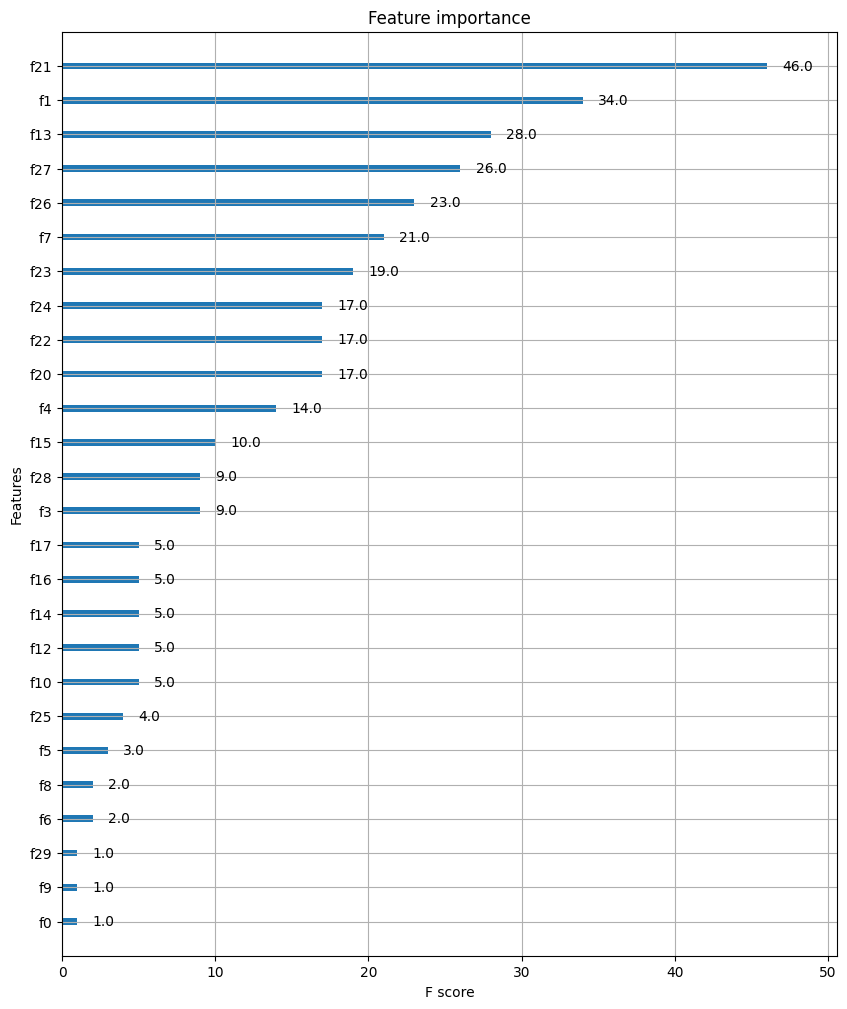

In [18]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb_wrapper, ax=ax)